# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import cohen_kappa_fn, f1_fn
from models import EnhancedCNNClassifier
from optim_utils import build_optimizer_and_scheduler
from torch import nn
from torchsummary import summary
from torchvision import transforms
from training import Trainer
from visualize import Visualizer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [23]:
import gc

def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

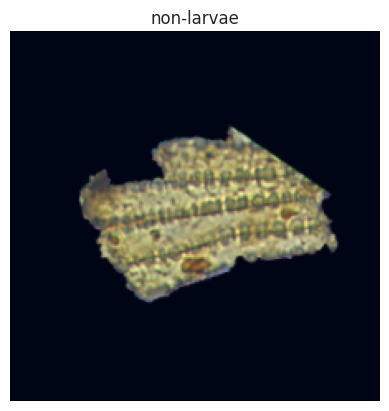

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

optim_config = {
    "scheduler": "onecycle",
    "max_lr": 2e-4,
    "lr": 1e-4,
    "eta_min": 1e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 6,
}

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="residual",
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 224, 224]              84
       BatchNorm2d-2          [-1, 3, 224, 224]               6
              ReLU-3          [-1, 3, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]             448
       BatchNorm2d-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
     ResidualBlock-7         [-1, 16, 224, 224]               0
         MaxPool2d-8         [-1, 16, 112, 112]               0
            Conv2d-9         [-1, 16, 112, 112]           2,320
      BatchNorm2d-10         [-1, 16, 112, 112]              32
             ReLU-11         [-1, 16, 112, 112]               0
           Conv2d-12         [-1, 32, 112, 112]           4,640
      BatchNorm2d-13         [-1, 32, 112, 112]              64
             ReLU-14         [-1, 32, 1

In [11]:
optimizer_cnn_0, scheduler_cnn_0 = build_optimizer_and_scheduler(
    cnn_0,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_0 = "weights/larvae-adv-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [12]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=60)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6891 | Val Loss: 0.6876 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6796 | Val Loss: 0.6871 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6729 | Val Loss: 0.6715 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6468 | Val Loss: 0.6393 | Train cohen_kappa_fn: 0.2275 | Val cohen_kappa_fn: -0.0122 | Train f1_fn: 0.9175 | Val f1_fn: 0.9116
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6118 | Val Loss: 0.6124 | Train cohen_kappa_fn: 0.3938 | Val cohen_kappa_fn: 0.4092 | Train f1_fn: 0.8332 | Val f1_fn: 0.8489
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5691 | Val Loss: 0.6145 | Train cohen_kappa_fn: 0.2882 | Val cohen_kappa_fn: 0.2779 | Train f1_fn: 0.7356 | Val f1_fn: 0.7112
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.5480 | Val Loss: 0.5460 | Train cohen_kappa_fn: 0.4727 | Val cohen_kappa_fn: 0.2967 | Train f1_fn: 0.9425 | Val f1_fn: 0.9310
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5011 | Val Loss: 0.4876 | Train cohen_kappa_fn: 0.5418 | Val cohen_kappa_fn: 0.5751 | Train f1_fn: 0.8909 | Val f1_fn: 0.9010
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4856 | Val Loss: 0.4391 | Train cohen_kappa_fn: 0.5853 | Val cohen_kappa_fn: 0.6431 | Train f1_fn: 0.9059 | Val f1_fn: 0.9302
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4114 | Val Loss: 0.4950 | Train cohen_kappa_fn: 0.2402 | Val cohen_kappa_fn: 0.2435 | Train f1_fn: 0.6758 | Val f1_fn: 0.6732
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.3689 | Val Loss: 0.2850 | Train cohen_kappa_fn: 0.7212 | Val cohen_kappa_fn: 0.7645 | Train f1_fn: 0.9466 | Val f1_fn: 0.9606
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3369 | Val Loss: 0.3492 | Train cohen_kappa_fn: 0.7621 | Val cohen_kappa_fn: 0.6951 | Train f1_fn: 0.9638 | Val f1_fn: 0.9584
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.3013 | Val Loss: 0.2928 | Train cohen_kappa_fn: 0.8030 | Val cohen_kappa_fn: 0.7016 | Train f1_fn: 0.9669 | Val f1_fn: 0.9515
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.3115 | Val Loss: 0.2811 | Train cohen_kappa_fn: 0.7751 | Val cohen_kappa_fn: 0.7296 | Train f1_fn: 0.9615 | Val f1_fn: 0.9573
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2648 | Val Loss: 0.3090 | Train cohen_kappa_fn: 0.4719 | Val cohen_kappa_fn: 0.4566 | Train f1_fn: 0.8542 | Val f1_fn: 0.8468
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2930 | Val Loss: 0.2677 | Train cohen_kappa_fn: 0.7768 | Val cohen_kappa_fn: 0.7288 | Train f1_fn: 0.9604 | Val f1_fn: 0.9551
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2537 | Val Loss: 0.3386 | Train cohen_kappa_fn: 0.8376 | Val cohen_kappa_fn: 0.7158 | Train f1_fn: 0.9757 | Val f1_fn: 0.9578
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2011 | Val Loss: 0.2347 | Train cohen_kappa_fn: 0.7903 | Val cohen_kappa_fn: 0.7197 | Train f1_fn: 0.9627 | Val f1_fn: 0.9531
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2051 | Val Loss: 0.2274 | Train cohen_kappa_fn: 0.6931 | Val cohen_kappa_fn: 0.6018 | Train f1_fn: 0.9372 | Val f1_fn: 0.9124
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.1771 | Val Loss: 0.2721 | Train cohen_kappa_fn: 0.8398 | Val cohen_kappa_fn: 0.7393 | Train f1_fn: 0.9738 | Val f1_fn: 0.9593
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1970 | Val Loss: 0.2079 | Train cohen_kappa_fn: 0.7576 | Val cohen_kappa_fn: 0.7305 | Train f1_fn: 0.9546 | Val f1_fn: 0.9478
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.1769 | Val Loss: 0.3517 | Train cohen_kappa_fn: 0.8823 | Val cohen_kappa_fn: 0.7464 | Train f1_fn: 0.9823 | Val f1_fn: 0.9635
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2191 | Val Loss: 0.2090 | Train cohen_kappa_fn: 0.8263 | Val cohen_kappa_fn: 0.7421 | Train f1_fn: 0.9697 | Val f1_fn: 0.9568
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1828 | Val Loss: 0.2767 | Train cohen_kappa_fn: 0.8664 | Val cohen_kappa_fn: 0.7766 | Train f1_fn: 0.9783 | Val f1_fn: 0.9647
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1583 | Val Loss: 0.2336 | Train cohen_kappa_fn: 0.8536 | Val cohen_kappa_fn: 0.8094 | Train f1_fn: 0.9751 | Val f1_fn: 0.9681
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1621 | Val Loss: 0.2108 | Train cohen_kappa_fn: 0.8722 | Val cohen_kappa_fn: 0.7668 | Train f1_fn: 0.9790 | Val f1_fn: 0.9628
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


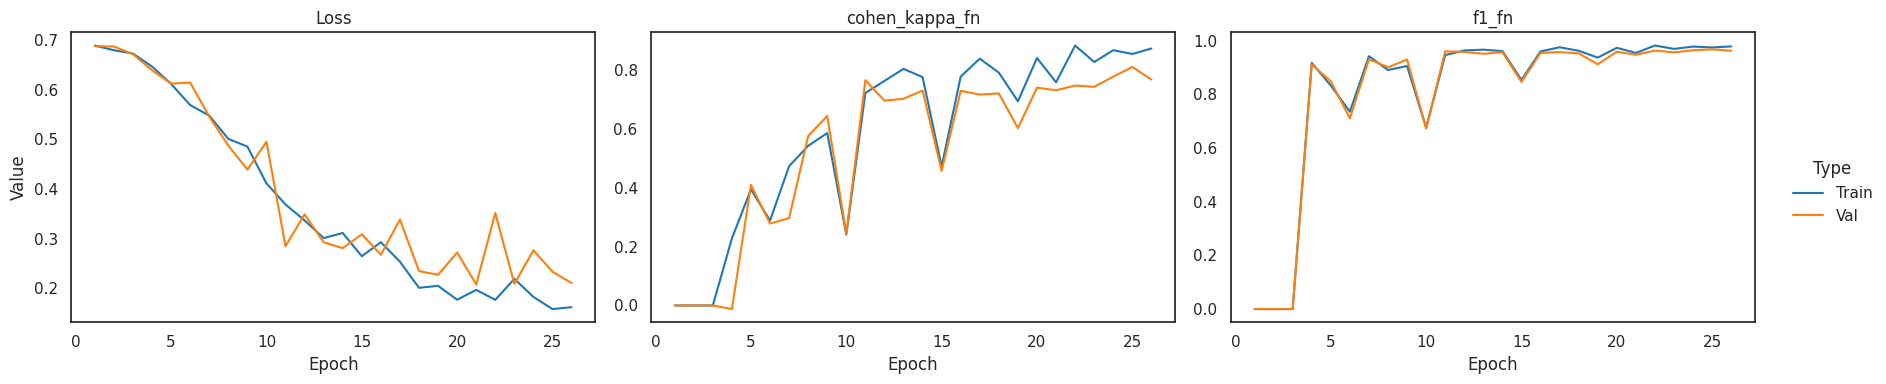

In [13]:
trainer_cnn_0.plot_epochs()

In [14]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1694 | Test cohen_kappa_fn: 0.7903 | Test f1_fn: 0.9634


#### Visualization

In [15]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

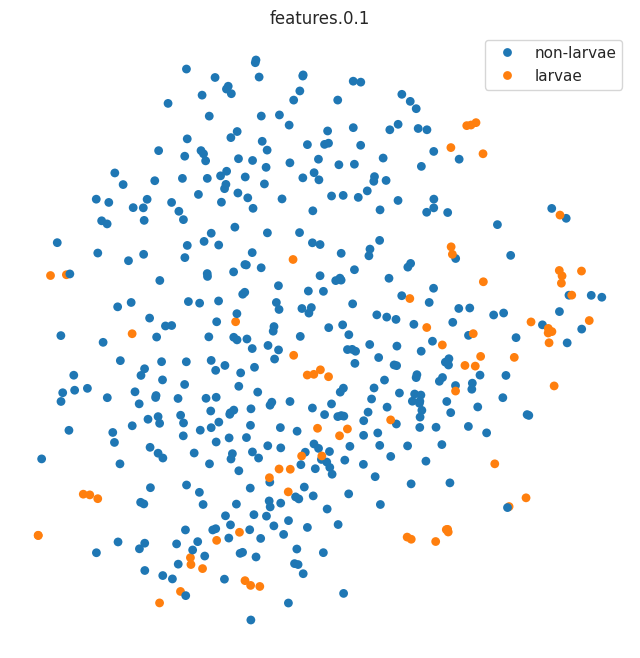

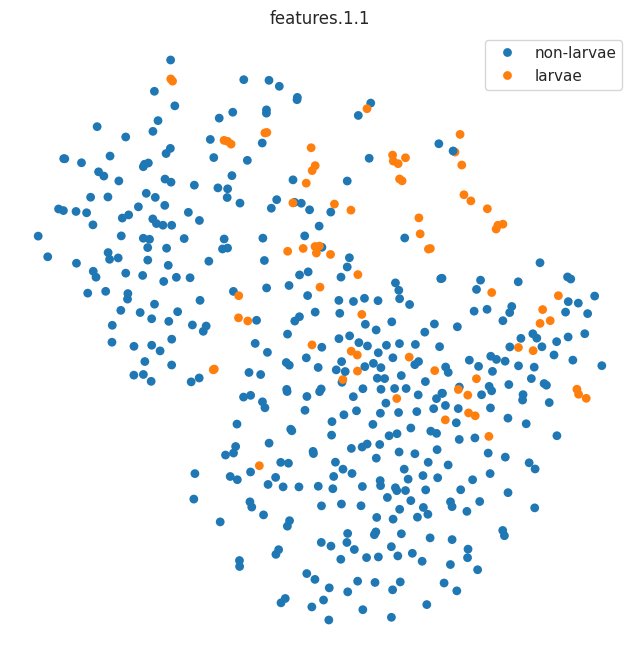

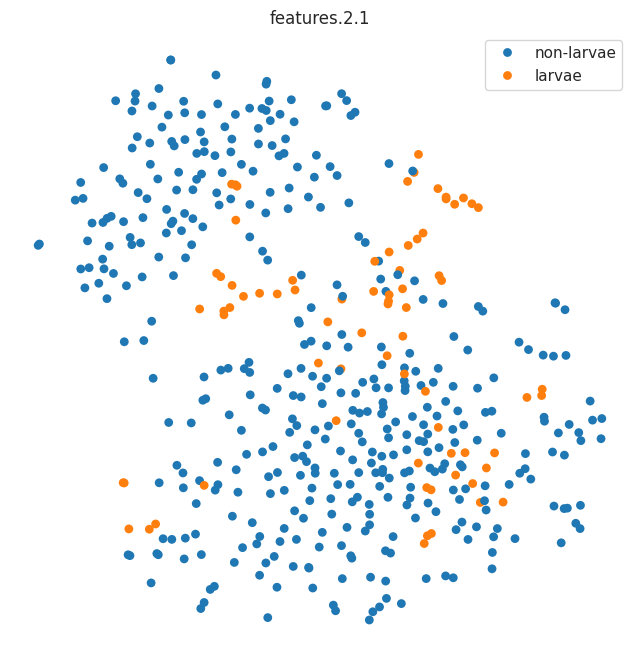

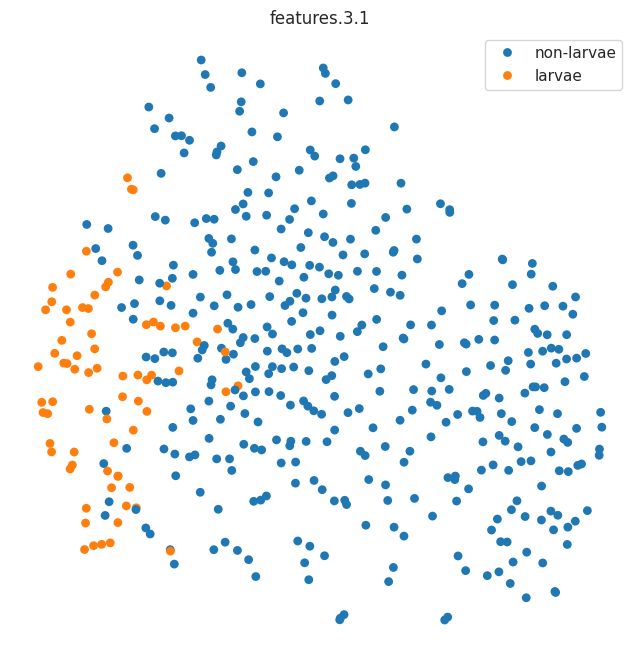

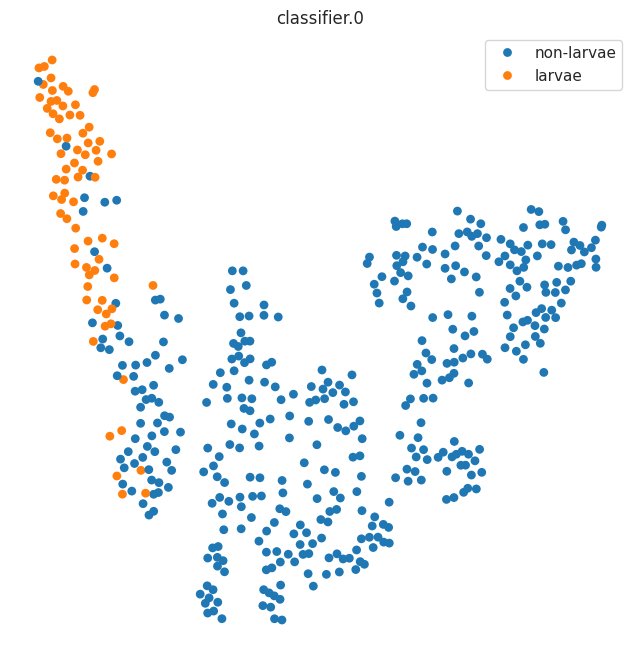

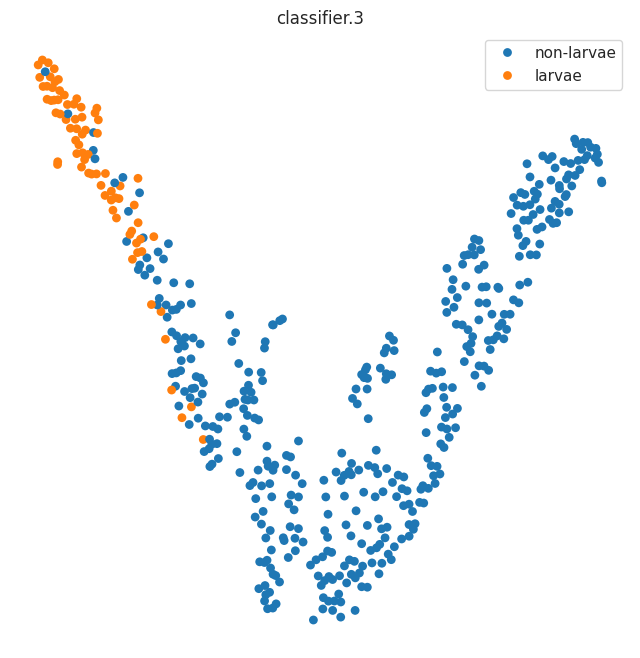

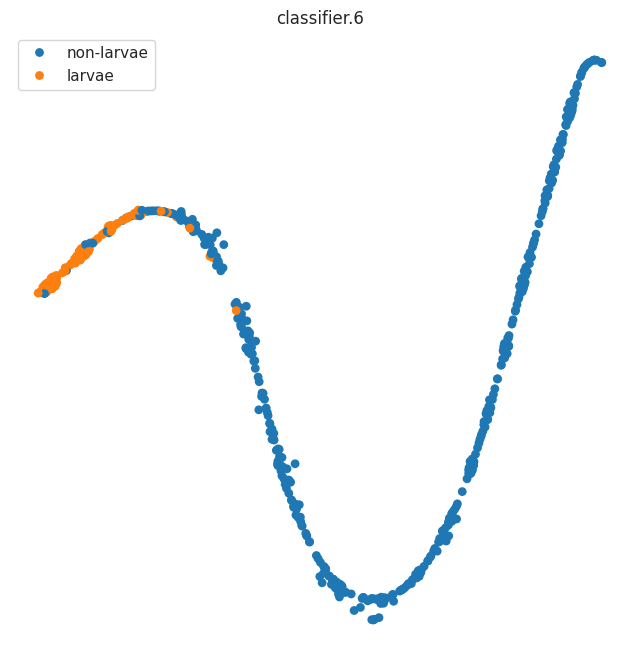

In [16]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


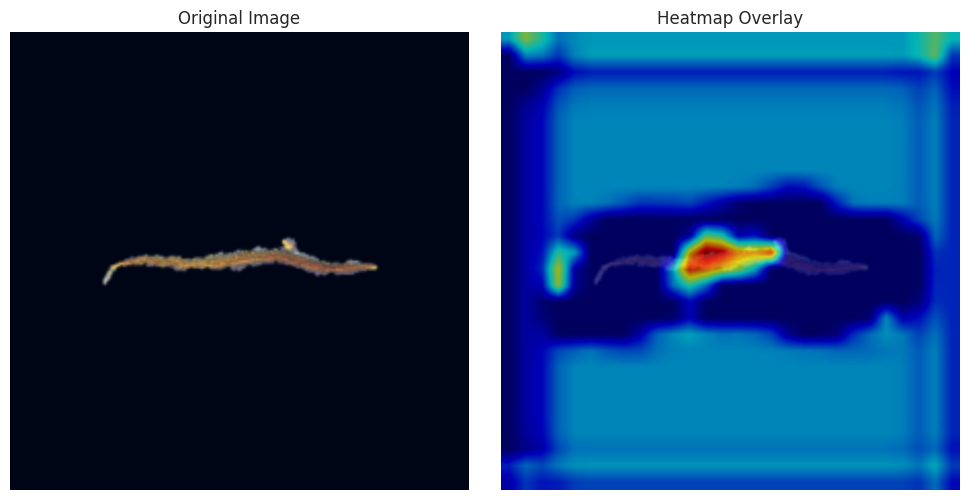

  Generating heatmap for Larvae...
  Predicted label is Larvae!


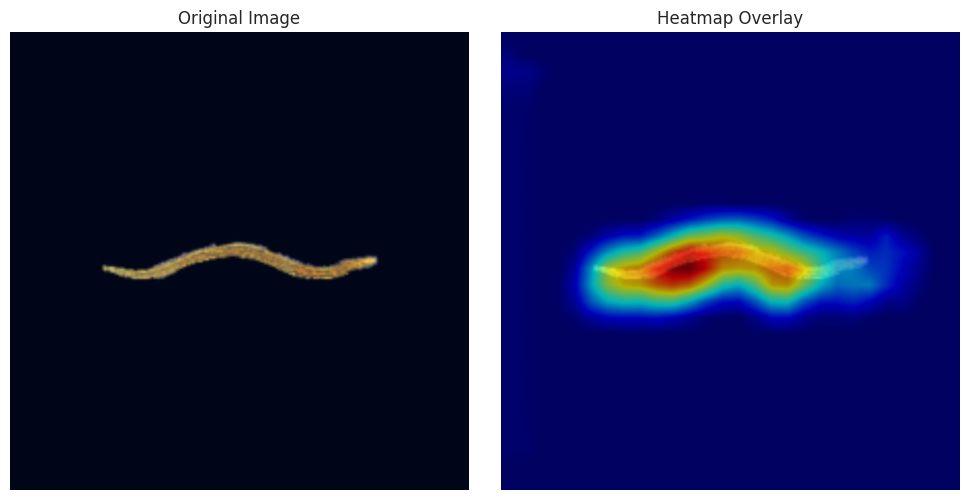

In [17]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [10]:
cnn_1 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="inception",
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 224]              16
            Conv2d-2          [-1, 4, 224, 224]              16
            Conv2d-3          [-1, 4, 224, 224]             148
            Conv2d-4          [-1, 4, 224, 224]              16
            Conv2d-5          [-1, 4, 224, 224]             404
         MaxPool2d-6          [-1, 3, 224, 224]               0
            Conv2d-7          [-1, 4, 224, 224]              16
       BatchNorm2d-8         [-1, 16, 224, 224]              32
    InceptionBlock-9         [-1, 16, 224, 224]               0
        MaxPool2d-10         [-1, 16, 112, 112]               0
           Conv2d-11          [-1, 8, 112, 112]             136
           Conv2d-12          [-1, 8, 112, 112]             136
           Conv2d-13          [-1, 8, 112, 112]             584
           Conv2d-14          [-1, 8, 1

In [11]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_1 = "weights/larvae-adv-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [12]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=60)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6917 | Val Loss: 0.6908 | Train cohen_kappa_fn: 0.1937 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.9228 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6893 | Val Loss: 0.6862 | Train cohen_kappa_fn: 0.1540 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.9217 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6825 | Val Loss: 0.6782 | Train cohen_kappa_fn: 0.2388 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.9148 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6616 | Val Loss: 0.6483 | Train cohen_kappa_fn: 0.2898 | Val cohen_kappa_fn: 0.3850 | Train f1_fn: 0.7836 | Val f1_fn: 0.8723
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6208 | Val Loss: 0.6004 | Train cohen_kappa_fn: 0.3221 | Val cohen_kappa_fn: 0.3518 | Train f1_fn: 0.7696 | Val f1_fn: 0.8078
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5710 | Val Loss: 0.5317 | Train cohen_kappa_fn: 0.3977 | Val cohen_kappa_fn: 0.5174 | Train f1_fn: 0.8268 | Val f1_fn: 0.8998
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5024 | Val Loss: 0.4737 | Train cohen_kappa_fn: 0.5019 | Val cohen_kappa_fn: 0.6535 | Train f1_fn: 0.8928 | Val f1_fn: 0.9464
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4600 | Val Loss: 0.4252 | Train cohen_kappa_fn: 0.6406 | Val cohen_kappa_fn: 0.7211 | Train f1_fn: 0.9389 | Val f1_fn: 0.9599
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4106 | Val Loss: 0.3709 | Train cohen_kappa_fn: 0.6672 | Val cohen_kappa_fn: 0.6968 | Train f1_fn: 0.9405 | Val f1_fn: 0.9517
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3770 | Val Loss: 0.3345 | Train cohen_kappa_fn: 0.5500 | Val cohen_kappa_fn: 0.6411 | Train f1_fn: 0.8989 | Val f1_fn: 0.9376
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3446 | Val Loss: 0.3267 | Train cohen_kappa_fn: 0.7807 | Val cohen_kappa_fn: 0.7795 | Train f1_fn: 0.9650 | Val f1_fn: 0.9669
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3318 | Val Loss: 0.2856 | Train cohen_kappa_fn: 0.5916 | Val cohen_kappa_fn: 0.6712 | Train f1_fn: 0.9138 | Val f1_fn: 0.9434
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3527 | Val Loss: 0.2819 | Train cohen_kappa_fn: 0.6576 | Val cohen_kappa_fn: 0.6357 | Train f1_fn: 0.9302 | Val f1_fn: 0.9331
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2960 | Val Loss: 0.2771 | Train cohen_kappa_fn: 0.7291 | Val cohen_kappa_fn: 0.7108 | Train f1_fn: 0.9530 | Val f1_fn: 0.9534
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3015 | Val Loss: 0.2661 | Train cohen_kappa_fn: 0.7470 | Val cohen_kappa_fn: 0.6836 | Train f1_fn: 0.9541 | Val f1_fn: 0.9476
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2558 | Val Loss: 0.2537 | Train cohen_kappa_fn: 0.8077 | Val cohen_kappa_fn: 0.7153 | Train f1_fn: 0.9667 | Val f1_fn: 0.9533
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2184 | Val Loss: 0.2571 | Train cohen_kappa_fn: 0.8233 | Val cohen_kappa_fn: 0.7795 | Train f1_fn: 0.9716 | Val f1_fn: 0.9669
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2658 | Val Loss: 0.2388 | Train cohen_kappa_fn: 0.8368 | Val cohen_kappa_fn: 0.7692 | Train f1_fn: 0.9730 | Val f1_fn: 0.9650
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2467 | Val Loss: 0.2392 | Train cohen_kappa_fn: 0.8449 | Val cohen_kappa_fn: 0.7692 | Train f1_fn: 0.9745 | Val f1_fn: 0.9650
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2378 | Val Loss: 0.2976 | Train cohen_kappa_fn: 0.8296 | Val cohen_kappa_fn: 0.7795 | Train f1_fn: 0.9723 | Val f1_fn: 0.9669
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1989 | Val Loss: 0.2209 | Train cohen_kappa_fn: 0.7820 | Val cohen_kappa_fn: 0.7460 | Train f1_fn: 0.9602 | Val f1_fn: 0.9567
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.2245 | Val Loss: 0.2354 | Train cohen_kappa_fn: 0.8089 | Val cohen_kappa_fn: 0.7934 | Train f1_fn: 0.9666 | Val f1_fn: 0.9664
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2400 | Val Loss: 0.2776 | Train cohen_kappa_fn: 0.8775 | Val cohen_kappa_fn: 0.7863 | Train f1_fn: 0.9807 | Val f1_fn: 0.9689
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1976 | Val Loss: 0.2452 | Train cohen_kappa_fn: 0.8549 | Val cohen_kappa_fn: 0.7692 | Train f1_fn: 0.9760 | Val f1_fn: 0.9650
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1719 | Val Loss: 0.2374 | Train cohen_kappa_fn: 0.8599 | Val cohen_kappa_fn: 0.7795 | Train f1_fn: 0.9767 | Val f1_fn: 0.9669
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1854 | Val Loss: 0.2901 | Train cohen_kappa_fn: 0.8818 | Val cohen_kappa_fn: 0.7863 | Train f1_fn: 0.9814 | Val f1_fn: 0.9689
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


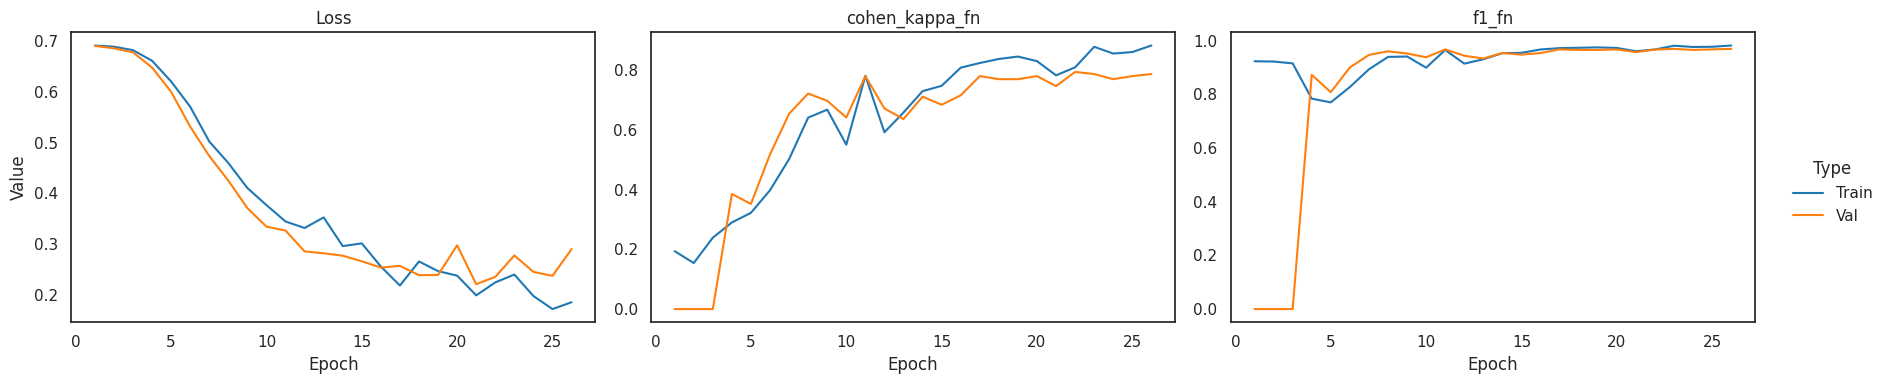

In [13]:
trainer_cnn_1.plot_epochs()

In [14]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2289 | Test cohen_kappa_fn: 0.8098 | Test f1_fn: 0.9689


#### Visualization

In [23]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

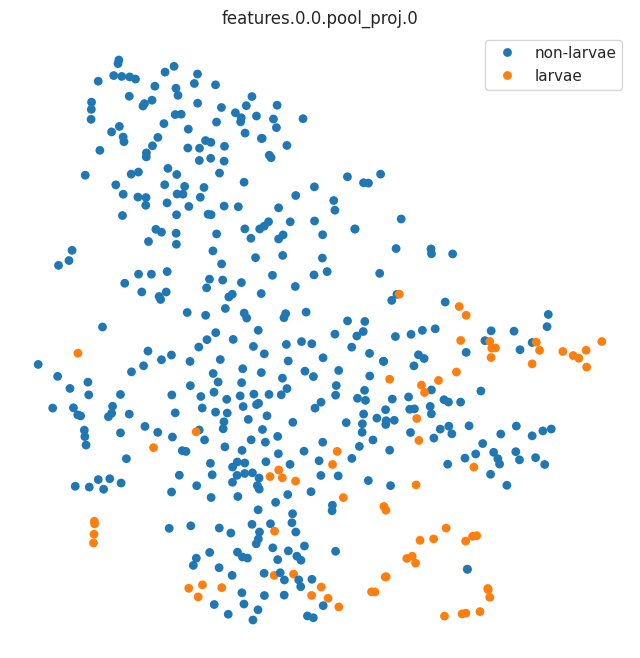

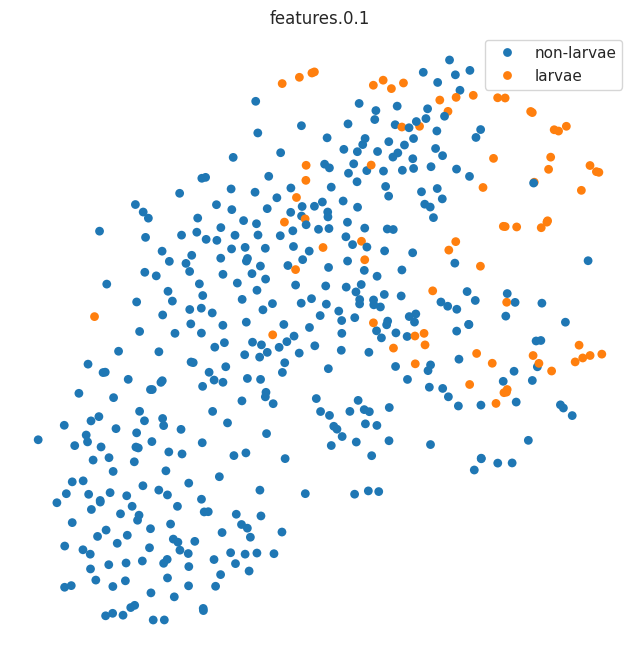

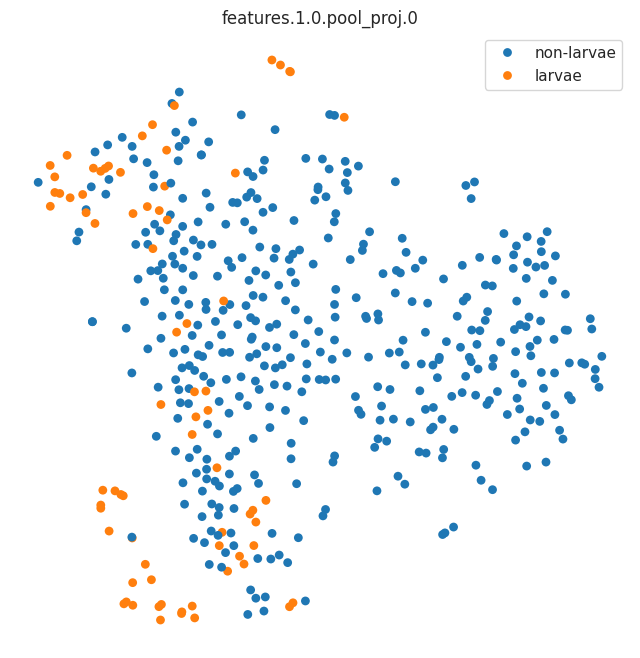

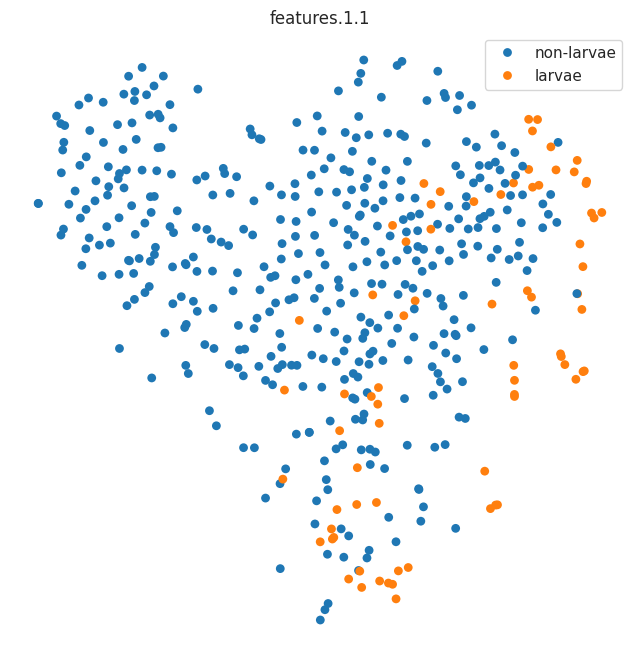

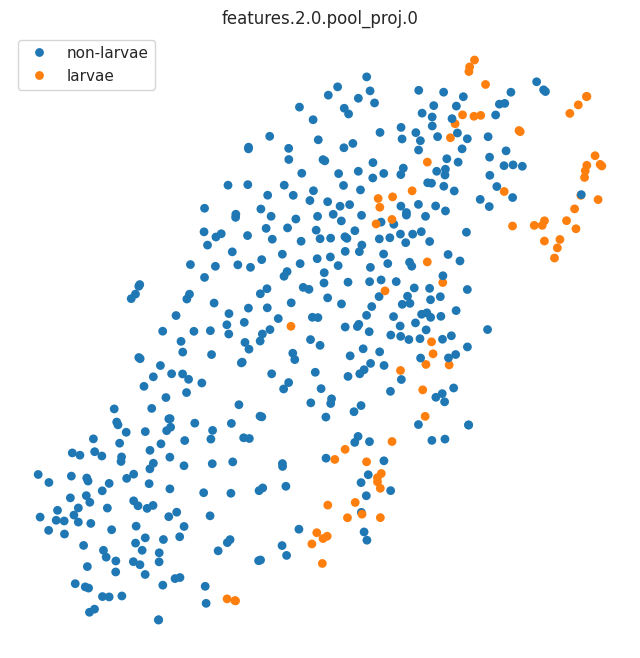

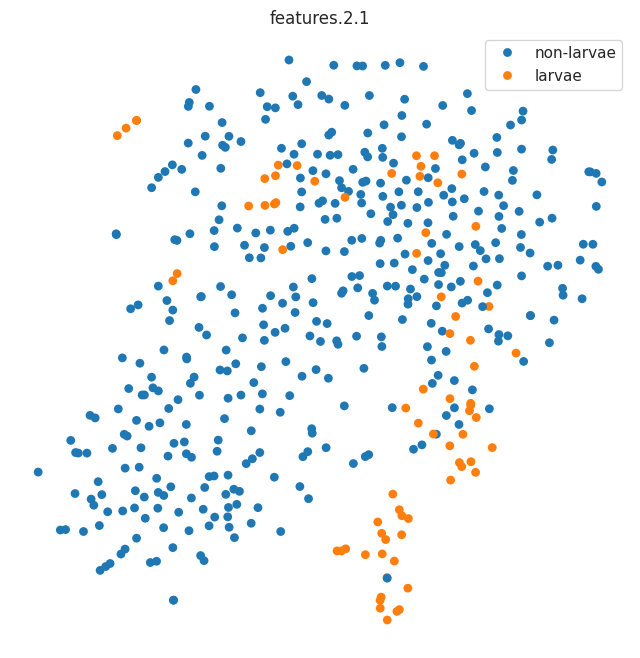

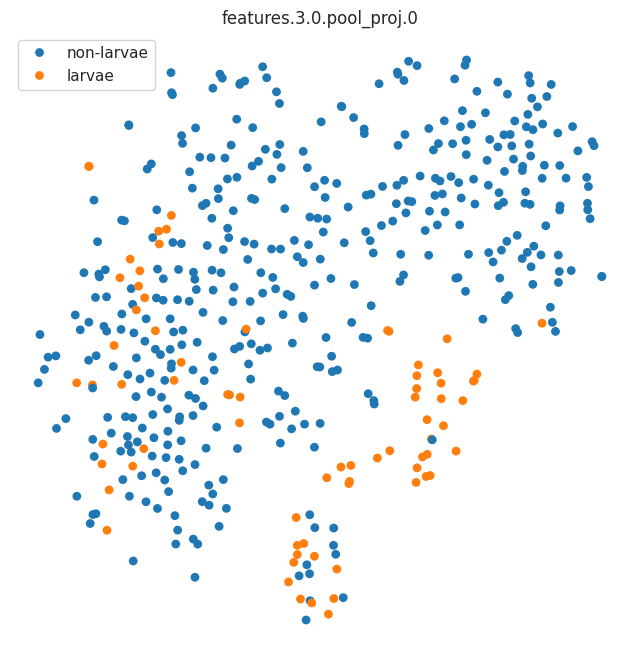

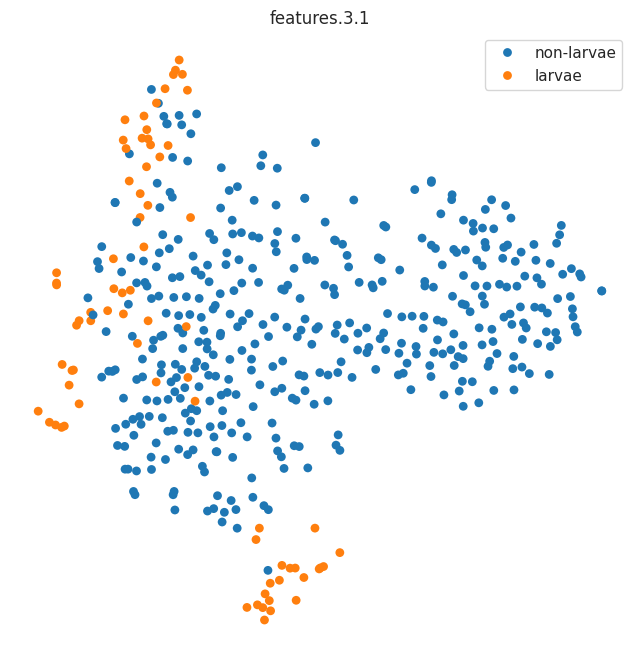

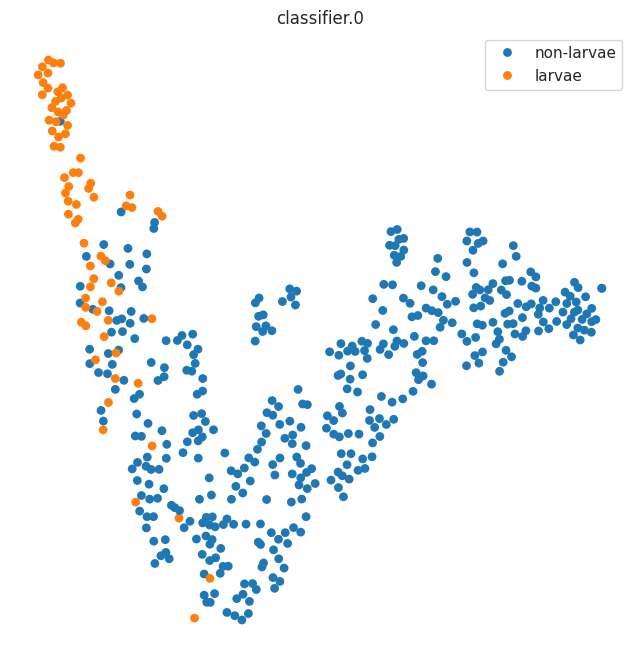

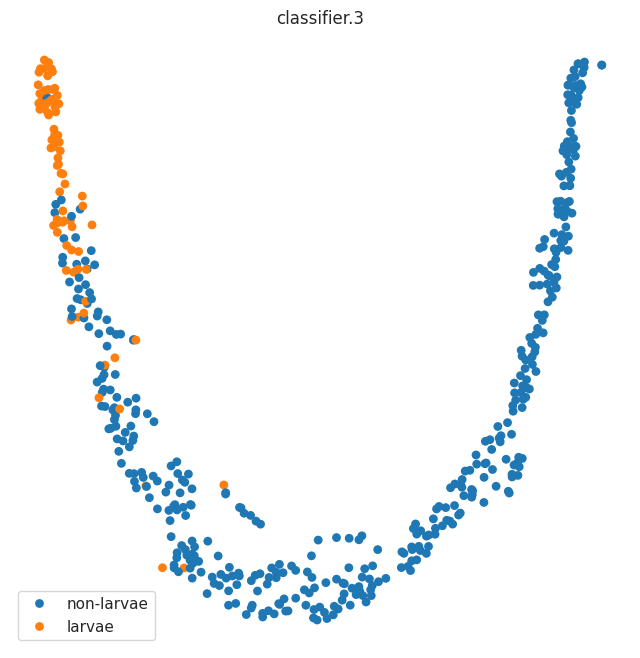

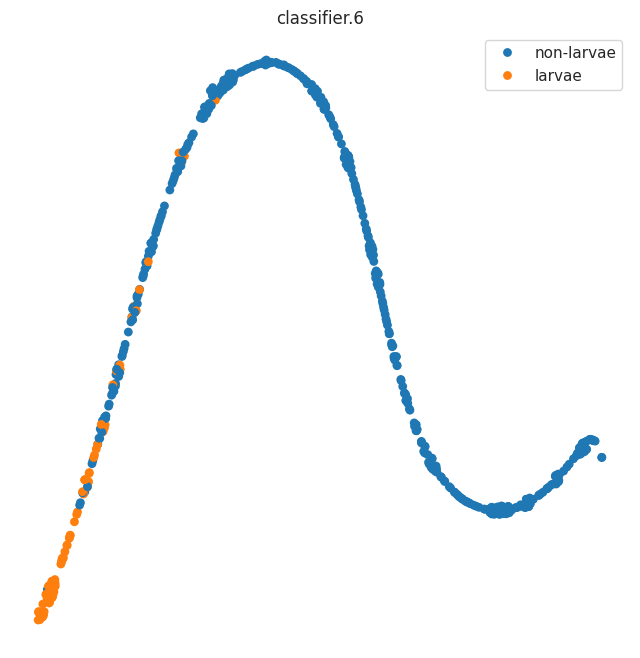

In [24]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


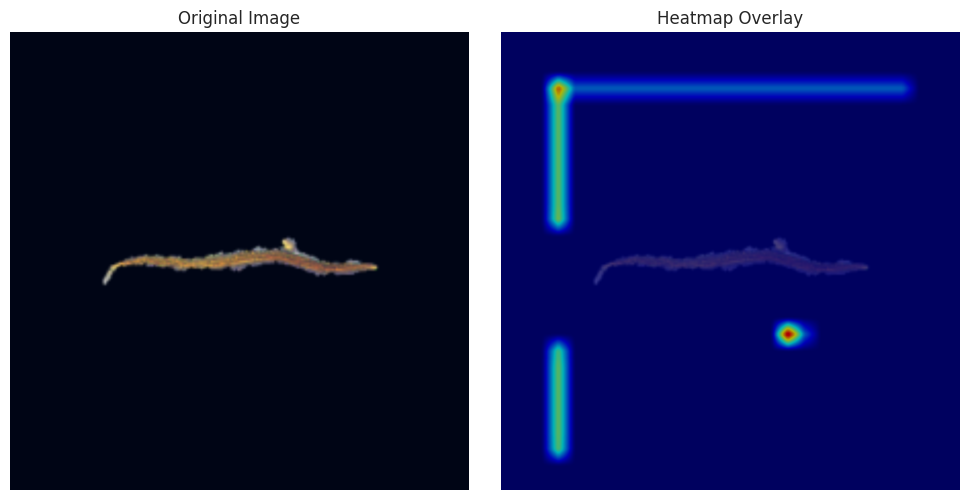

  Generating heatmap for Larvae...
  Predicted label is Larvae!


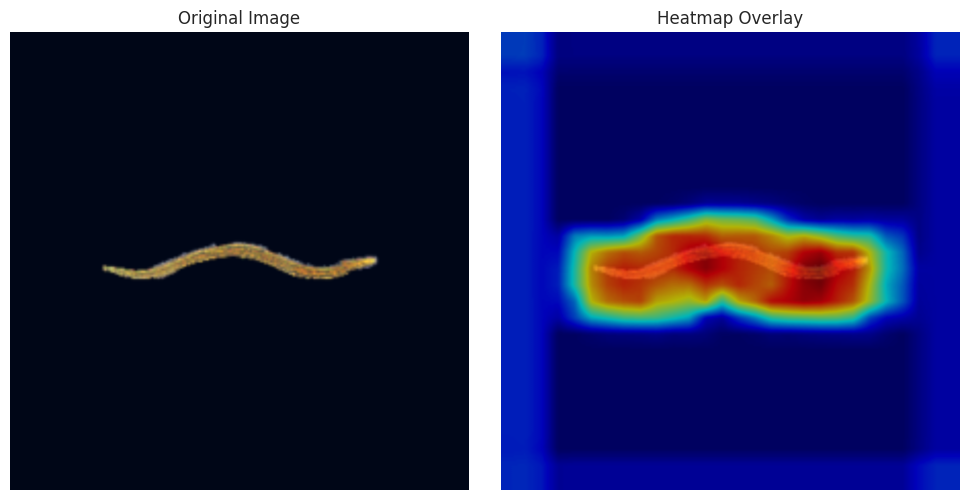

In [25]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [26]:
cnn_2 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="se",
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
 AdaptiveAvgPool2d-3             [-1, 16, 1, 1]               0
            Linear-4                    [-1, 1]              17
              ReLU-5                    [-1, 1]               0
            Linear-6                   [-1, 16]              32
           Sigmoid-7                   [-1, 16]               0
           SEBlock-8         [-1, 16, 224, 224]               0
         MaxPool2d-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 32, 112, 112]           4,640
             ReLU-11         [-1, 32, 112, 112]               0
AdaptiveAvgPool2d-12             [-1, 32, 1, 1]               0
           Linear-13                    [-1, 2]              66
             ReLU-14                   

In [27]:
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(
    cnn_2,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_2 = "weights/larvae-adv-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [28]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=60)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 5 | Train Loss: 0.6926 | Val Loss: 0.6930 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 6 | Train Loss: 0.6927 | Val Loss: 0.6929 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 7 | Train Loss: 0.6929 | Val Loss: 0.6930 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 8 | Train Loss: 0.6923 | Val Loss: 0.6925 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 9 | Train Loss: 0.6928 | Val Loss: 0.6926 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 10 | Train Loss: 0.6924 | Val Loss: 0.6923 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 11 | Train Loss: 0.6931 | Val Loss: 0.6921 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 12 | Train Loss: 0.6919 | Val Loss: 0.6904 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 13 | Train Loss: 0.6909 | Val Loss: 0.6886 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 14 | Train Loss: 0.6854 | Val Loss: 0.6790 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 15 | Train Loss: 0.6691 | Val Loss: 0.6552 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 16 | Train Loss: 0.6448 | Val Loss: 0.6365 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.6226 | Val Loss: 0.6300 | Train cohen_kappa_fn: 0.1830 | Val cohen_kappa_fn: 0.1301 | Train f1_fn: 0.7321 | Val f1_fn: 0.6911
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.6088 | Val Loss: 0.6314 | Train cohen_kappa_fn: 0.1813 | Val cohen_kappa_fn: 0.1505 | Train f1_fn: 0.7271 | Val f1_fn: 0.6943
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.6234 | Val Loss: 0.6352 | Train cohen_kappa_fn: 0.2103 | Val cohen_kappa_fn: 0.1670 | Train f1_fn: 0.7082 | Val f1_fn: 0.6838
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.6103 | Val Loss: 0.6304 | Train cohen_kappa_fn: 0.2071 | Val cohen_kappa_fn: 0.1877 | Train f1_fn: 0.6870 | Val f1_fn: 0.6793
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.6099 | Val Loss: 0.6326 | Train cohen_kappa_fn: 0.1882 | Val cohen_kappa_fn: 0.1788 | Train f1_fn: 0.7165 | Val f1_fn: 0.7064
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.5966 | Val Loss: 0.6225 | Train cohen_kappa_fn: 0.2155 | Val cohen_kappa_fn: 0.1944 | Train f1_fn: 0.6999 | Val f1_fn: 0.6963
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.5837 | Val Loss: 0.6566 | Train cohen_kappa_fn: 0.2203 | Val cohen_kappa_fn: 0.1765 | Train f1_fn: 0.7314 | Val f1_fn: 0.7305
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.5858 | Val Loss: 0.6102 | Train cohen_kappa_fn: 0.1851 | Val cohen_kappa_fn: 0.1917 | Train f1_fn: 0.6313 | Val f1_fn: 0.6746
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.5803 | Val Loss: 0.6149 | Train cohen_kappa_fn: 0.2138 | Val cohen_kappa_fn: 0.1972 | Train f1_fn: 0.6839 | Val f1_fn: 0.6993
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.5694 | Val Loss: 0.6647 | Train cohen_kappa_fn: 0.2119 | Val cohen_kappa_fn: 0.1707 | Train f1_fn: 0.7233 | Val f1_fn: 0.7248
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.5651 | Val Loss: 0.6485 | Train cohen_kappa_fn: 0.1910 | Val cohen_kappa_fn: 0.1931 | Train f1_fn: 0.6831 | Val f1_fn: 0.7037
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.5940 | Val Loss: 0.6222 | Train cohen_kappa_fn: 0.1762 | Val cohen_kappa_fn: 0.1827 | Train f1_fn: 0.6138 | Val f1_fn: 0.6537
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.5816 | Val Loss: 0.6387 | Train cohen_kappa_fn: 0.2141 | Val cohen_kappa_fn: 0.2028 | Train f1_fn: 0.6914 | Val f1_fn: 0.7053
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


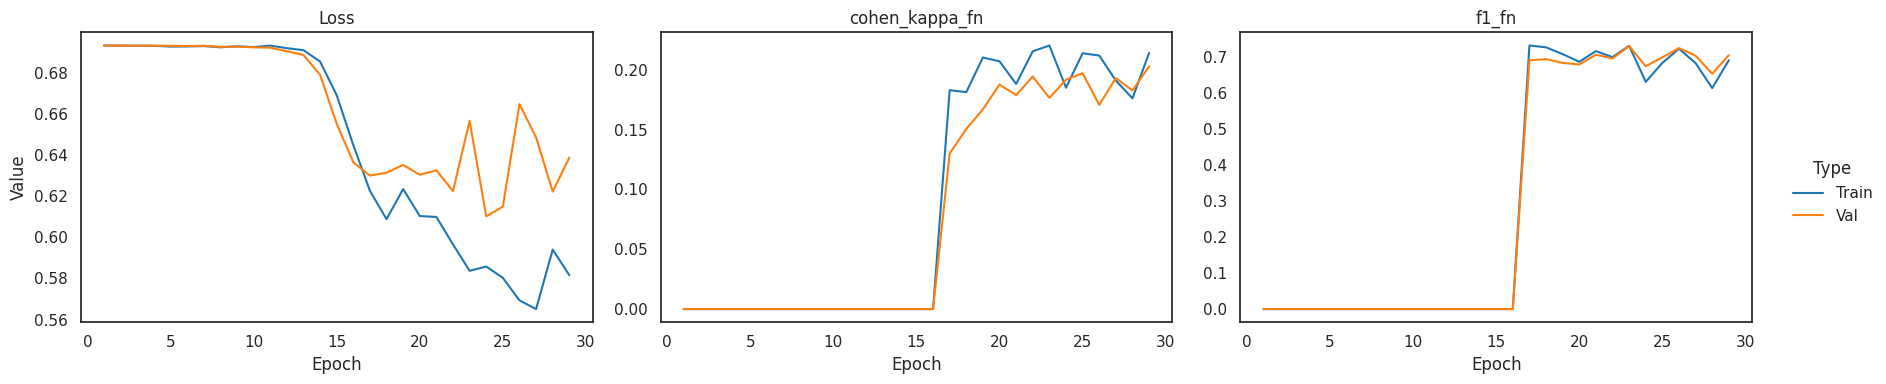

In [29]:
trainer_cnn_2.plot_epochs()

In [30]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.5766 | Test cohen_kappa_fn: 0.2379 | Test f1_fn: 0.7352


#### Visualization

In [31]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

In [32]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

ValueError: n_components=2 must be between 1 and min(n_samples, n_features)=1 with svd_solver='randomized'

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


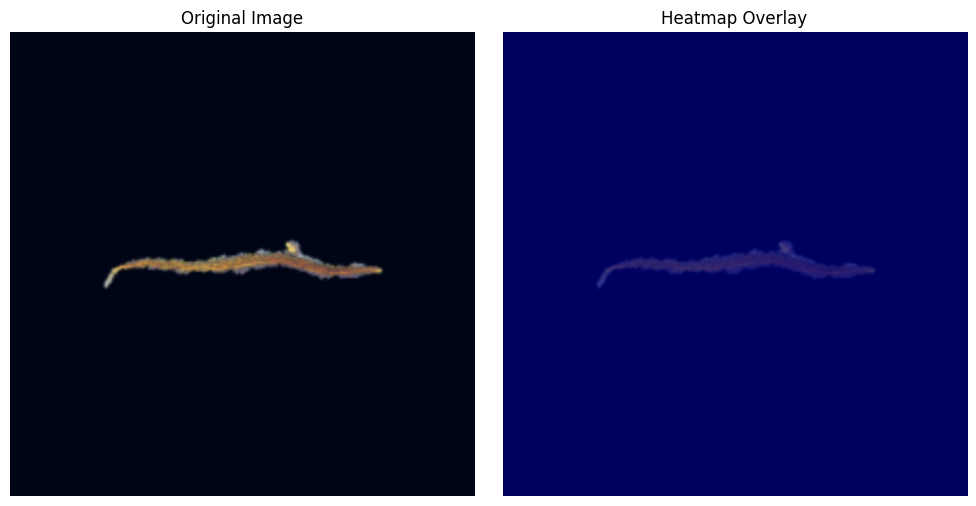

  Generating heatmap for Larvae...
  Predicted label is Larvae!


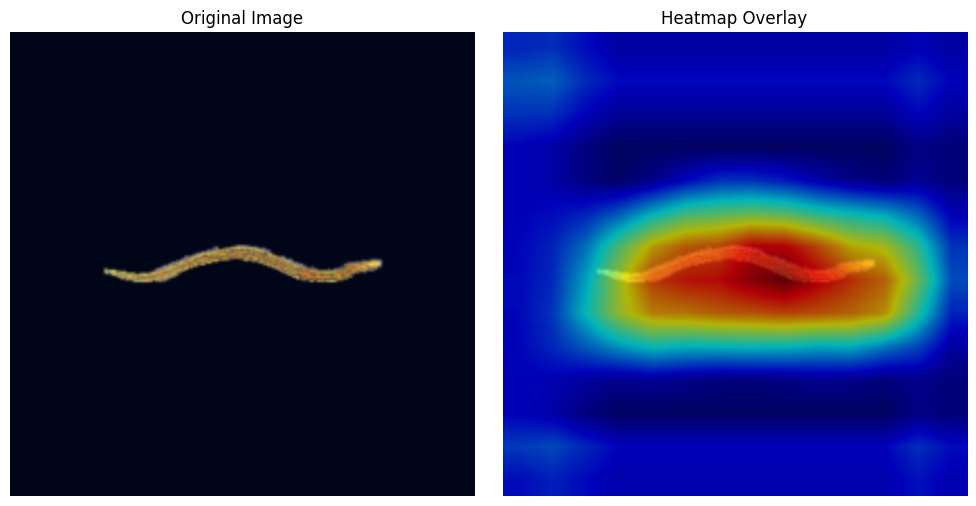

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [24]:
cnn_3 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="cbam",
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
 AdaptiveMaxPool2d-3             [-1, 16, 1, 1]               0
 AdaptiveAvgPool2d-4             [-1, 16, 1, 1]               0
            Conv2d-5              [-1, 1, 1, 1]              16
              ReLU-6              [-1, 1, 1, 1]               0
            Conv2d-7             [-1, 16, 1, 1]              16
            Conv2d-8              [-1, 1, 1, 1]              16
              ReLU-9              [-1, 1, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]              16
          Sigmoid-11             [-1, 16, 1, 1]               0
 ChannelAttention-12             [-1, 16, 1, 1]               0
           Conv2d-13          [-1, 1, 224, 224]              99
          Sigmoid-14          [-1, 1, 2

In [25]:
cbam_optim_config = {
    "scheduler": "onecycle",
    "max_lr": 1e-3,
    "lr": 3e-4,
    "eta_min": 5e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 6,
}
optimizer_cnn_3, scheduler_cnn_3 = build_optimizer_and_scheduler(
    cnn_3,
    cbam_optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_3 = "weights/larvae-adv-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [26]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=60)

📘 Epoch 1 | Train Loss: 0.6857 | Val Loss: 0.6655 | Train cohen_kappa_fn: 0.0440 | Val cohen_kappa_fn: -0.0360 | Train f1_fn: 0.8215 | Val f1_fn: 0.8525
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6239 | Val Loss: 0.8310 | Train cohen_kappa_fn: 0.0786 | Val cohen_kappa_fn: -0.0142 | Train f1_fn: 0.8003 | Val f1_fn: 0.8000
  ❄️ No improvement, model won't be saved!


📘 Epoch 3 | Train Loss: 0.6610 | Val Loss: 0.6339 | Train cohen_kappa_fn: 0.1001 | Val cohen_kappa_fn: 0.1008 | Train f1_fn: 0.4192 | Val f1_fn: 0.4706
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6072 | Val Loss: 0.6370 | Train cohen_kappa_fn: 0.1647 | Val cohen_kappa_fn: 0.1544 | Train f1_fn: 0.6055 | Val f1_fn: 0.6253
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.6001 | Val Loss: 0.6422 | Train cohen_kappa_fn: 0.1527 | Val cohen_kappa_fn: 0.1534 | Train f1_fn: 0.5708 | Val f1_fn: 0.6005
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.5914 | Val Loss: 0.6575 | Train cohen_kappa_fn: 0.1902 | Val cohen_kappa_fn: 0.1793 | Train f1_fn: 0.6589 | Val f1_fn: 0.6885
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.5806 | Val Loss: 0.6282 | Train cohen_kappa_fn: 0.2212 | Val cohen_kappa_fn: 0.2068 | Train f1_fn: 0.6852 | Val f1_fn: 0.7422
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5528 | Val Loss: 0.6190 | Train cohen_kappa_fn: 0.3249 | Val cohen_kappa_fn: 0.2233 | Train f1_fn: 0.8075 | Val f1_fn: 0.8799
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5291 | Val Loss: 0.5799 | Train cohen_kappa_fn: 0.3075 | Val cohen_kappa_fn: 0.3148 | Train f1_fn: 0.7798 | Val f1_fn: 0.8809
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.5228 | Val Loss: 0.5613 | Train cohen_kappa_fn: 0.2621 | Val cohen_kappa_fn: 0.3251 | Train f1_fn: 0.7192 | Val f1_fn: 0.8313
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4869 | Val Loss: 0.7466 | Train cohen_kappa_fn: 0.6040 | Val cohen_kappa_fn: 0.2432 | Train f1_fn: 0.9455 | Val f1_fn: 0.9278
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.4882 | Val Loss: 0.6941 | Train cohen_kappa_fn: 0.5404 | Val cohen_kappa_fn: 0.3225 | Train f1_fn: 0.9233 | Val f1_fn: 0.9326
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.4744 | Val Loss: 0.6435 | Train cohen_kappa_fn: 0.5430 | Val cohen_kappa_fn: 0.3383 | Train f1_fn: 0.9223 | Val f1_fn: 0.9324
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.4247 | Val Loss: 0.6345 | Train cohen_kappa_fn: 0.4490 | Val cohen_kappa_fn: 0.4350 | Train f1_fn: 0.8612 | Val f1_fn: 0.9064
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.3947 | Val Loss: 0.4905 | Train cohen_kappa_fn: 0.6051 | Val cohen_kappa_fn: 0.6111 | Train f1_fn: 0.9271 | Val f1_fn: 0.9498
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.3733 | Val Loss: 0.7436 | Train cohen_kappa_fn: 0.6553 | Val cohen_kappa_fn: 0.4197 | Train f1_fn: 0.9563 | Val f1_fn: 0.9391
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.3971 | Val Loss: 0.3985 | Train cohen_kappa_fn: 0.4854 | Val cohen_kappa_fn: 0.5466 | Train f1_fn: 0.8747 | Val f1_fn: 0.9205
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.3272 | Val Loss: 0.4689 | Train cohen_kappa_fn: 0.6607 | Val cohen_kappa_fn: 0.5871 | Train f1_fn: 0.9389 | Val f1_fn: 0.9418
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.3145 | Val Loss: 0.3295 | Train cohen_kappa_fn: 0.5146 | Val cohen_kappa_fn: 0.5676 | Train f1_fn: 0.8777 | Val f1_fn: 0.9094
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2647 | Val Loss: 0.5234 | Train cohen_kappa_fn: 0.7342 | Val cohen_kappa_fn: 0.6534 | Train f1_fn: 0.9620 | Val f1_fn: 0.9573
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.3820 | Val Loss: 0.6096 | Train cohen_kappa_fn: 0.6692 | Val cohen_kappa_fn: 0.6090 | Train f1_fn: 0.9576 | Val f1_fn: 0.9541
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.3029 | Val Loss: 0.6447 | Train cohen_kappa_fn: 0.7395 | Val cohen_kappa_fn: 0.6464 | Train f1_fn: 0.9582 | Val f1_fn: 0.9574
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2993 | Val Loss: 0.3989 | Train cohen_kappa_fn: 0.3429 | Val cohen_kappa_fn: 0.3623 | Train f1_fn: 0.7743 | Val f1_fn: 0.8095
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.4236 | Val Loss: 0.4375 | Train cohen_kappa_fn: 0.7636 | Val cohen_kappa_fn: 0.6387 | Train f1_fn: 0.9619 | Val f1_fn: 0.9491
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


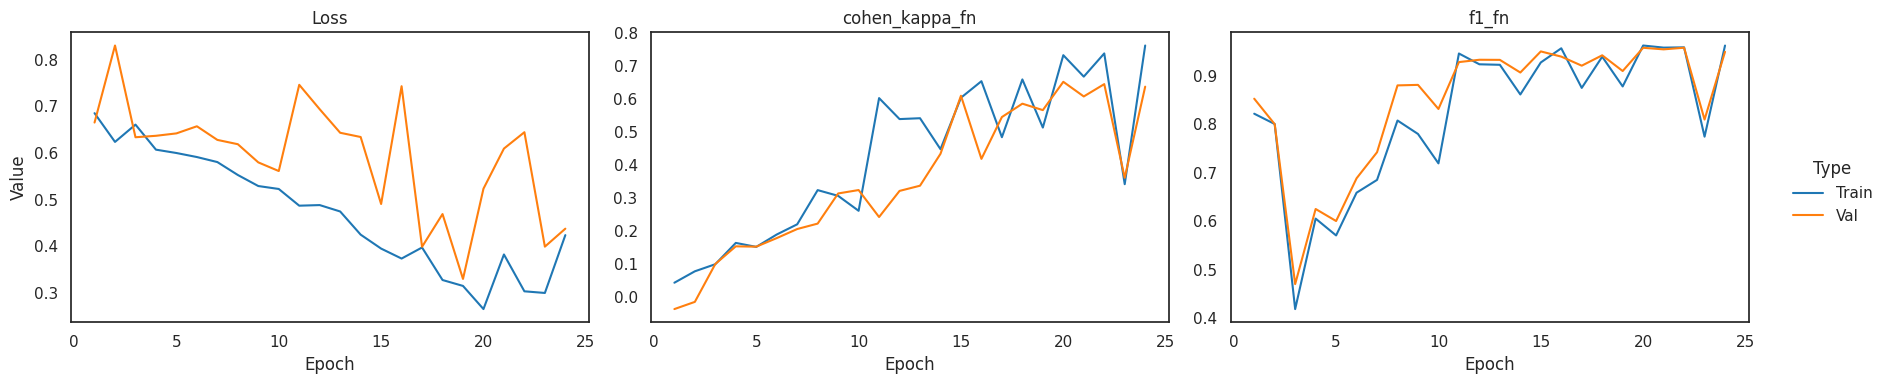

In [27]:
trainer_cnn_3.plot_epochs()

In [28]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.3460 | Test cohen_kappa_fn: 0.5887 | Test f1_fn: 0.9167


#### Visualization

In [ ]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

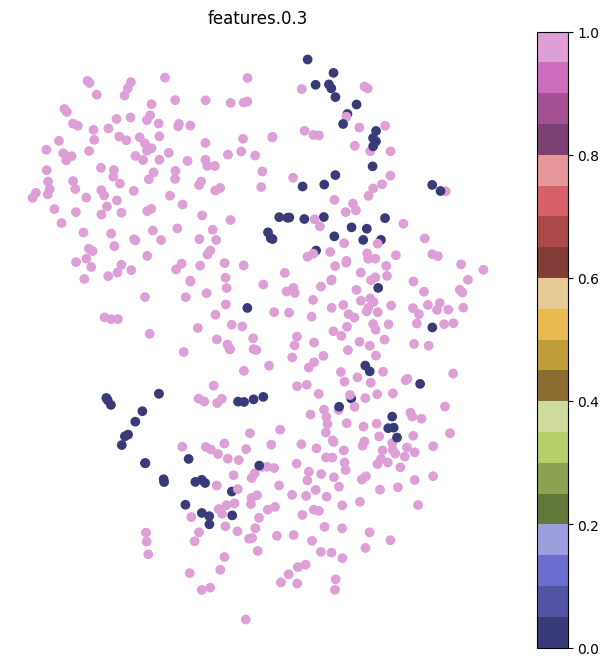

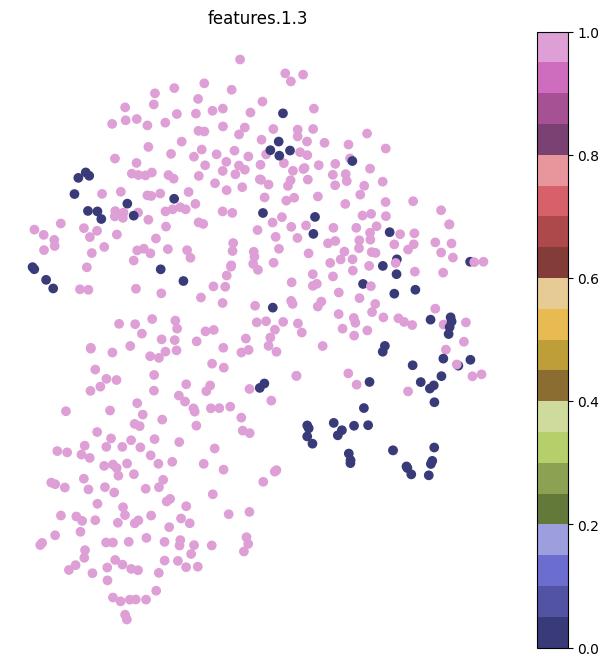

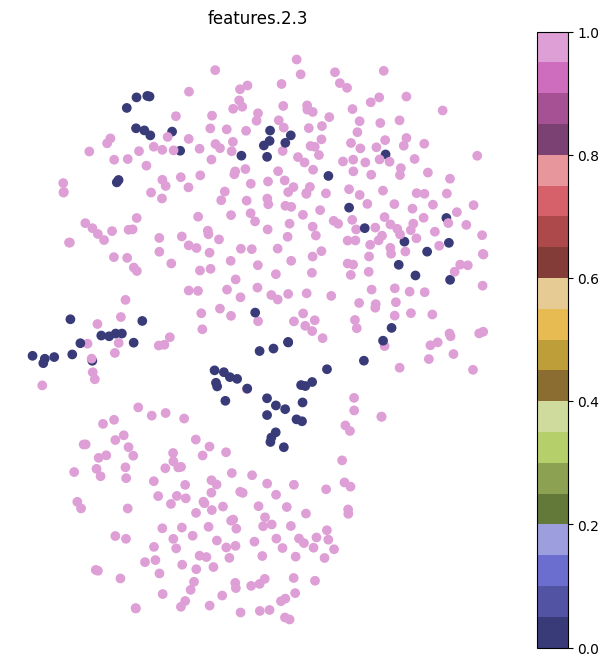

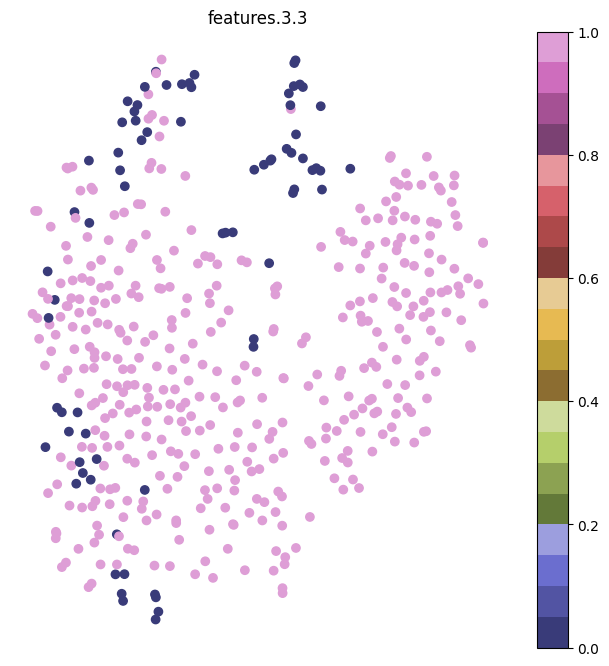

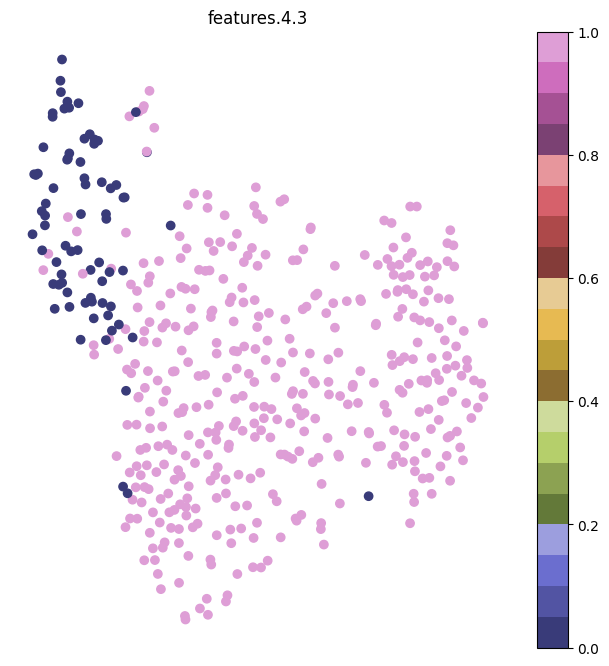

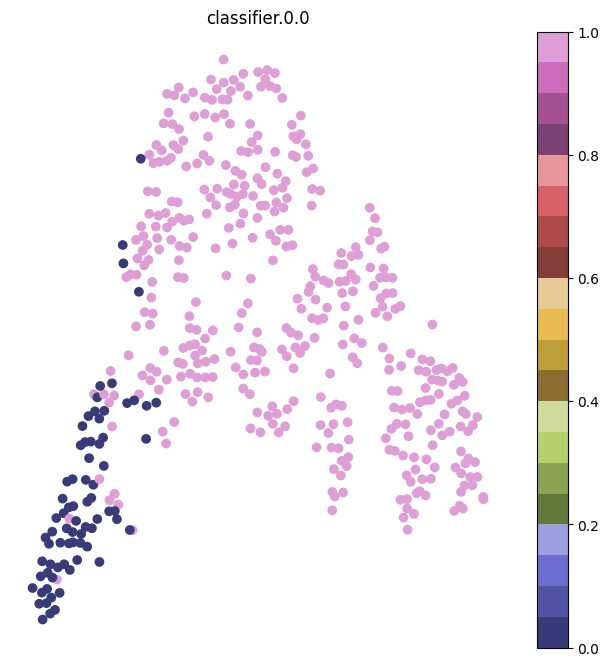

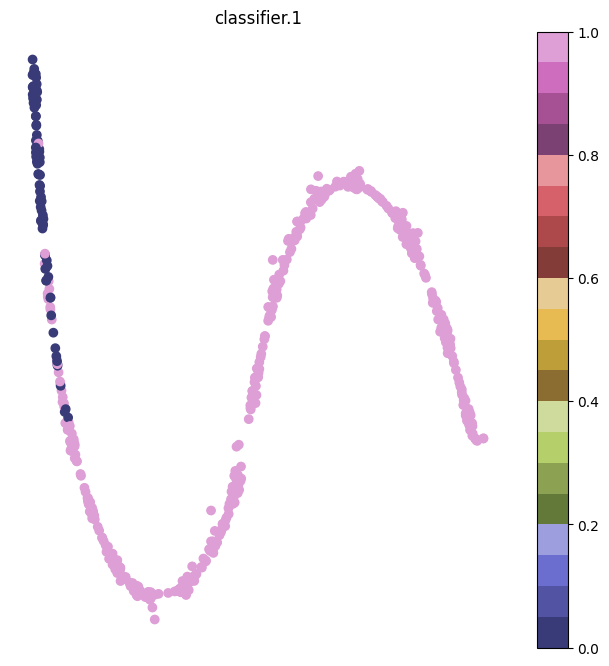

In [ ]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


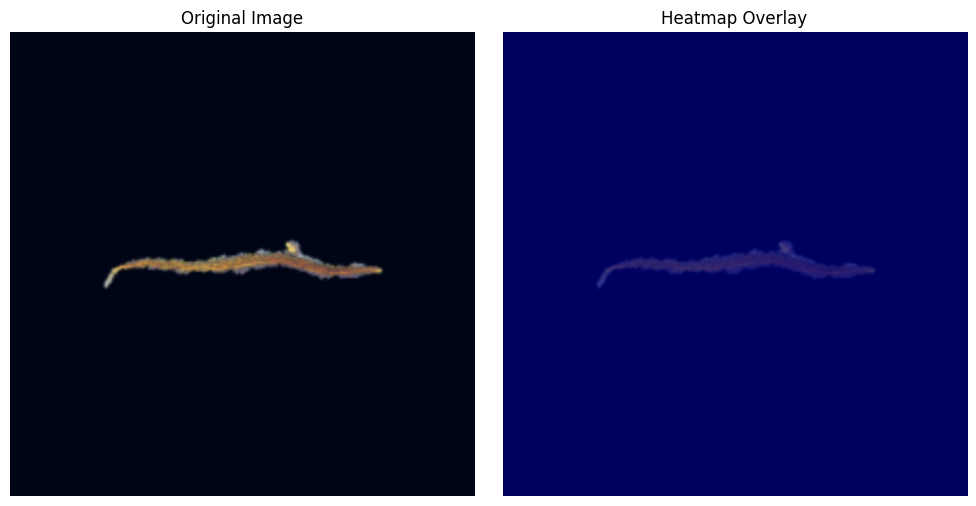

  Generating heatmap for Larvae...
  Predicted label is Larvae!


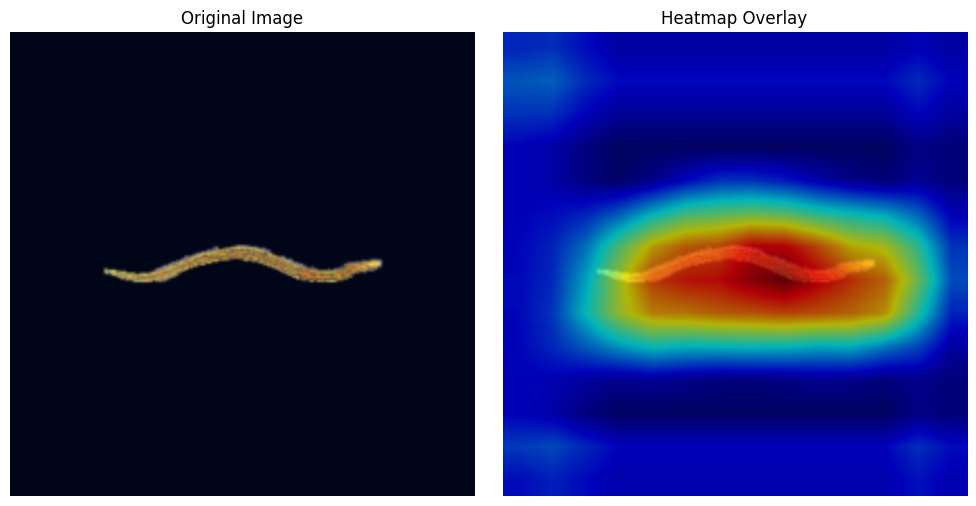

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break